<a href="https://colab.research.google.com/github/asdacdsfca/dsc100_private_use/blob/main/Copy_of_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install psycopg2-binary faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.9 MB/s eta 0:00:00


**Install and setup PostgreSQL**

Warning: This notebook is designed to be run in a Google Colab only. It installs packages on the system and requires sudo access. If you want to run it in a local Jupyter notebook, please proceed with caution.

In order to demo the usage on Google Colab you will install PostgreSQL server. The password and an empty database is also needed.

If you are not running this notebook on Google Colab, or you prefer to use an existing database, please skip the following setup and proceed to the next section.

In [ ]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 10.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package cron.
(Reading database ... 122531 files and directories currently installed.)
Preparing to unpack .../0-cron_3.0pl1-136ubuntu1_amd64.deb ...
Unpacking cron (3.0pl1-136ubuntu1) ...
Selecting previously unselected package logrotate.
Preparing to unpack .../1-logrotate_3.14.0-4ubuntu3_amd64.deb ...
Unpacking logrotate (3.14.0-4ubuntu3) ...
Selecting previously unselected package netbase.
Preparing to unpack .../2-netbase_6.1_all.deb ...
Unpacking netbase (6.1) ...
Selecting previously unselected package pos

Setup necessary environmental variables

In [ ]:
%env TFIO_DEMO_DATABASE_NAME=tfio_demo
%env TFIO_DEMO_DATABASE_HOST=localhost
%env TFIO_DEMO_DATABASE_PORT=5432
%env TFIO_DEMO_DATABASE_USER=postgres
%env TFIO_DEMO_DATABASE_PASS=postgres

env: TFIO_DEMO_DATABASE_NAME=tfio_demo
env: TFIO_DEMO_DATABASE_HOST=localhost
env: TFIO_DEMO_DATABASE_PORT=5432
env: TFIO_DEMO_DATABASE_USER=postgres
env: TFIO_DEMO_DATABASE_PASS=postgres


In [ ]:
# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
# Setup a database with name `dsc100_demo_demo` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS dsc100_demo2;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE dsc100_demo2;'

ALTER ROLE
NOTICE:  database "dsc100_demo2" does not exist, skipping
DROP DATABASE
CREATE DATABASE


In [ ]:
import psycopg2
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from faker import Faker
def time_query(query):
    start_time = time.time()
    cur.execute(query)
    conn.commit()
    return time.time() - start_time

# Connect to your postgres DB
import psycopg2
conn = psycopg2.connect(
    dbname="dsc100_demo2",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

cur = conn.cursor()



Now, we need to establish a connection to the PostgreSQL database. 

In [ ]:

# Create the table
data_size=1000000
cur.execute("""
    DROP TABLE IF EXISTS people;
    CREATE TABLE people (
        id SERIAL PRIMARY KEY,
        name VARCHAR(100),
        income INTEGER
    );
""")

# Populate the table with random data
names = ['John Doe', 'Jane Doe', 'Alice', 'Bob', 'Charlie', 'David']
for i in range(data_size):
    cur.execute("INSERT INTO people (name, income) VALUES (%s, %s)", 
                (random.choice(names), i))

conn.commit()



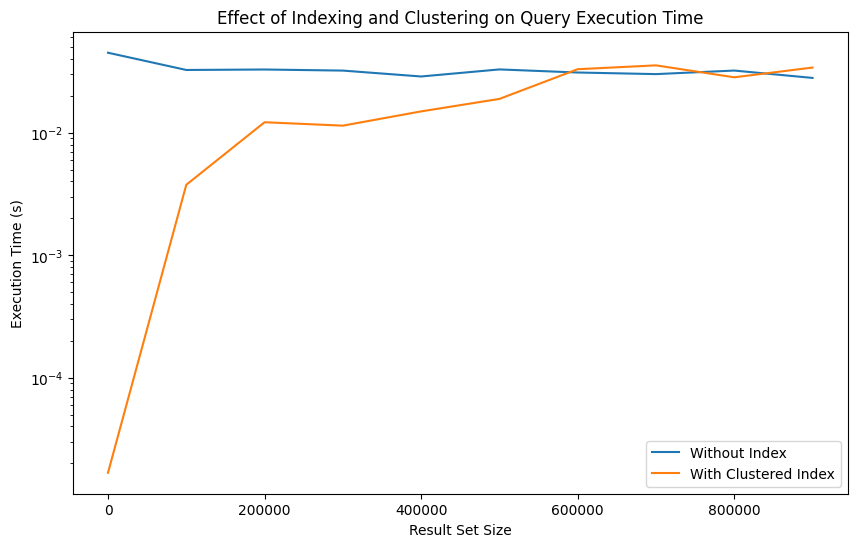

In [ ]:
# Query without index
result_sizes = list(range(0, data_size, 100000))

num_executions=20
# Drop the index on the name and income field
cur.execute("DROP INDEX IF EXISTS idx_income")
# Drop the index on the name and income field
cur.execute("DROP INDEX IF EXISTS idx_name")

cur.execute("DROP INDEX IF EXISTS idx_random_order")


# Disable indexes and enable sequential scan
#cur.execute("SET enable_seqscan = ON")
#cur.execute("SET enable_indexscan = OFF")
#cur.execute("SET enable_bitmapscan = OFF")

times_without_index = []
for size in result_sizes:
    query = f"SELECT * FROM people"
    exec_time=0
    for _ in range(num_executions):
      exec_time = + time_query(query)
    times_without_index.append(exec_time/num_executions)



# Enable indexes and disable sequential scan
cur.execute("SET enable_seqscan = OFF")
cur.execute("SET enable_indexscan = ON")
cur.execute("SET enable_bitmapscan = ON")

# Create index
cur.execute("CREATE INDEX idx_income ON people using btree (income)")
cur.execute("CLUSTER people USING idx_income")
conn.commit()






# Query with clustered index
times_with_clustered_index = []

for size in result_sizes:
    query = f"SELECT * FROM people WHERE income <= {size}"
    exec_time=0
    for _ in range(num_executions):
      exec_time = + time_query(query)
    times_with_clustered_index.append(exec_time/num_executions)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(result_sizes, times_without_index, label='Without Index')
plt.plot(result_sizes, times_with_clustered_index, label='With Clustered Index')
plt.xlabel('Result Set Size')
plt.ylabel('Execution Time (s)')
plt.legend()
#plt.yscale('log')
plt.title('Effect of Indexing and Clustering on Query Execution Time')
plt.show()

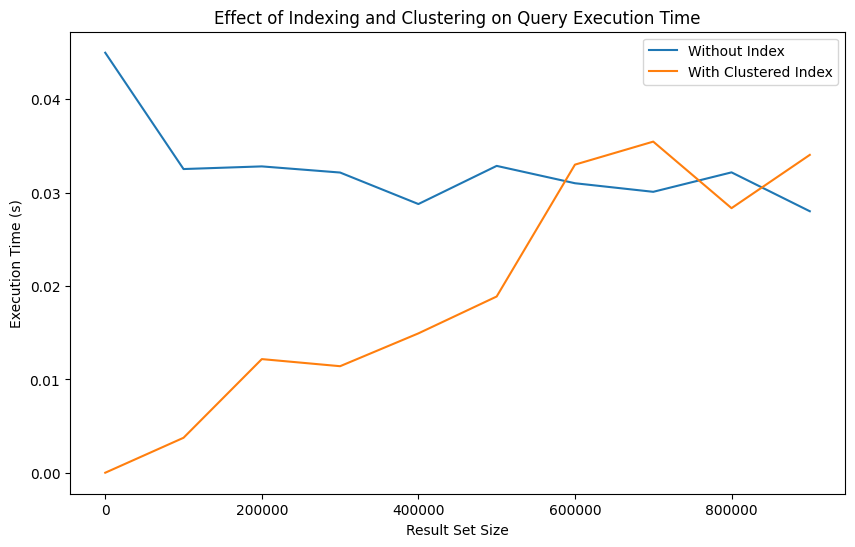

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(result_sizes, times_without_index, label='Without Index')
plt.plot(result_sizes, times_with_clustered_index, label='With Clustered Index')
plt.xlabel('Result Set Size')
plt.ylabel('Execution Time (s)')
plt.legend()
#plt.yscale('log')
plt.title('Effect of Indexing and Clustering on Query Execution Time')
plt.show()